# Rozpoznawanie mowy - projekt

In [1]:
from scipy.io import wavfile
from matplotlib import pyplot as plt
import numpy as np
import sys
import wave
import scipy.signal
import os
import librosa
import librosa.util
from dtw import dtw
from numpy.linalg import norm
import librosa.display

### 1. Funkcja do wczytywania plików z sygnałami (load_voice_signal()). Funkcja normalizuje sygnał poprzez podzielenie sygnału przez moduł sygnału.

In [42]:
def load_voice_signal(filename):
    samplerate, data = wavfile.read('commends/' + filename + '.wav')
    words = data / np.amax(np.absolute(data))
    words = words[::,0]
    timestamps = np.array([i[0] / samplerate for i in np.ndindex(words.shape)])
    return words, timestamps

#### Przykład wizualizacji fali dźwiękowej

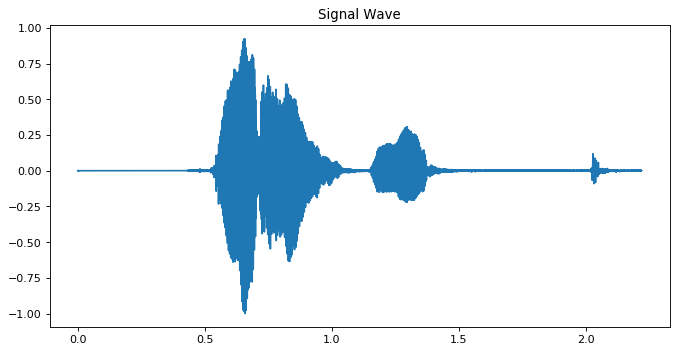

In [207]:
words, timestamps = load_voice_signal('G11')

#y = words[32000:70000]
#x = timestamps[32000:70000]
y = words
x = timestamps
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Signal Wave')

plt.plot(x,y)

plt.show()

### 2. Funkcja, która wyciąga cechy sygnału (extract_features()).

In [90]:
def extract_features(word):
    my_mfcc = np.mean(librosa.feature.mfcc(y = word, sr = 44100, n_mfcc = 40).T, axis = 0)
    my_mfcc = np.array([my_mfcc])
    return my_mfcc

### 3. Podział na zbiór uczący (train_words, train_commands) - 108 próbek (80 %) oraz zbiór testujący (test_words, test_command) - 27 próbek (20 %). -> do usunięcia?

In [148]:
commands = ['otwórz', 'zamknij', 'gorąco', 'zimno', 'ciemno', 'jasno', 'stop', 'rozwiń', 'zasłoń']

train_words = []
train_commands = []
test_words = []
test_commands = []

# zbiór uczący
for k in range(0,9):
    for j in range(1, 5):
        a = j + k*5
        

        path = 'G' + str(a)
        train_words.append(load_voice_signal(path)[0])
        train_commands.append(commands[k])

        path = 'J' + str(a)
        train_words.append(load_voice_signal(path)[0])
        train_commands.append(commands[k])

        path = 'O' + str(a)
        train_words.append(load_voice_signal(path)[0])
        train_commands.append(commands[k])

#zbiór testujący
for j in range(0,9):
    a = 5*j + 5

    path = 'G' + str(a)
    test_words.append(load_voice_signal(path)[0])
    test_commands.append(commands[j])

    path = 'J' + str(a)
    test_words.append(load_voice_signal(path)[0])
    test_commands.append(commands[j])

    path = 'O' + str(a)
    test_words.append(load_voice_signal(path)[0])
    test_commands.append(commands[j])



5
10
15
20
25
30
35
40
45


# Ekstrakcja cech i podział na zbiór uczący i testowy w stosunku 4:1
### podział przeprowadzony w sposób losowy

In [178]:
from sklearn.model_selection import train_test_split

commands = ['otwórz', 'zamknij', 'gorąco', 'zimno', 'ciemno', 'jasno', 'stop', 'rozwiń', 'zasłoń']

file_ids, commands = zip(*[(person + str(cmd_idx * 5 + n_record + 1), cmd)
                      for cmd_idx, cmd in enumerate(commands)
                      for person in 'OJG'
                      for n_record in range(5)])

words = [load_voice_signal(file_id)[0] for file_id in file_ids]

features = np.squeeze([extract_features(word) for word in words])

(features_train, features_test,
words_train, words_test,
commands_train, commands_test) = train_test_split(features, words, commands, test_size=0.2)

#### Trzeba znaleźć jakiś algorytm uczenia, przykładowy algorytm: https://blog.manash.me/building-a-dead-simple-word-recognition-engine-using-convnet-in-keras-25e72c19c12b

Uważam, że różnice pomiędzy tymi samymi słowami sa na tyle duże, że nie bedziemy w stanie nauczyć sieci => można zapisać to we wnioskach

### 4. Wyciągnięcie cech sygnałów  -> do usunięcia?

In [81]:
#zbiór uczący
train_features = []
for i in range(0, len(train_words)):
    feature = extract_features(train_words[i])
    train_features.append(feature)
    
train_features = np.squeeze(train_features)

#zbiór testujący
test_features = []
for i in range(0, len(test_words)):
    feature = extract_features(test_words[i])
    test_features.append(feature)

test_features = np.squeeze(test_features)


5. Porównanie sygnałów używając DWT

Różnica pomiędzy tymi różnymi komendami 189.70612182715178


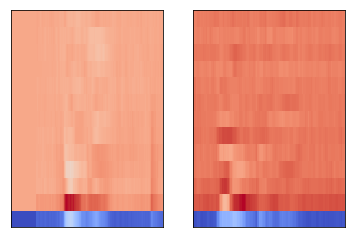

In [192]:
fs = 44100
same_words1 = [word for word, cmd in zip(words_test, commands_test) if cmd == 'zamknij']
same_words2 = [word for word, cmd in zip(words_test, commands_test) if cmd == 'stop']
word_1 = librosa.feature.mfcc(same_words1[1], fs, n_mfcc = 13)
plt.subplot(1, 2, 1)
librosa.display.specshow(word_1)
word_2 = librosa.feature.mfcc(same_words1[2], fs, n_mfcc = 13)
plt.subplot(1, 2, 2)

librosa.display.specshow(word_2)

dist, cost, acc_cost, path = dtw(word_2.T, word_1.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
print('Różnica pomiędzy tymi różnymi komendami', dist)

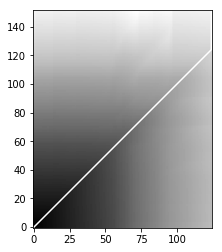

In [174]:
plt.imshow(acc_cost.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.show()